<a href="https://colab.research.google.com/github/akurukunda01/Fruits-and-Veggie-CNN/blob/main/Veg_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to this Fruit and Vegetable Image Classification Project!

This notebook demonstrates the process of building and evaluating convolutional neural networks (CNNs) for classifying images of fruits and vegetables.

## Project Overview
The goal of this project is to train a model that can accurately identify different types of fruits and vegetables from images. We will explore the use of pre-trained models and transfer learning to achieve high accuracy on a diverse dataset.

## Dataset
We will be using the "moltean/fruits" dataset from Kaggle, which contains a large collection of images of various fruits and vegetables. The dataset is split into training and testing sets, and has over 223 different classes.

## Approach
1.  **Data Loading and Preparation**: Download the dataset and prepare the image data for input into our models using PyTorch's data loading and augmentation capabilities.
2.  **Model Selection and Setup**: Set up two different CNN architectures, ResNet50 and EfficientNetB0, leveraging pre-trained weights for transfer learning.
3.  **Training**: Train both models on the prepared training dataset, monitoring their performance over epochs.
4.  **Testing**: Evaluate the trained models on the unseen test dataset to assess their generalization ability and compare their performance.
5.  **Prediction**: Use the trained model to predict the class of a single image.

# GPU Connection
Import pytorch into the notebook, and ensure that it works with the local gpu. Check the cuda and device connection, which if succesful will be displayed in the output.


In [ ]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 5090
Using device: cuda


# Dataset function
This section works with the dataset downloaded from Kaggle.

The code in this section downloads the "moltean/fruits" dataset from Kaggle using `kagglehub`. It then lists the contents of the downloaded dataset directory to show the available subfolders. The subsequent code cells navigate into the 'fruits-360\_100x100' and 'fruits-360' subdirectories and list their contents, revealing the 'Test' and 'Training' folders which contain the image data. Finally, it lists the contents of the 'Training' directory to show the individual fruit and vegetable classes available in the dataset.

In [ ]:
import kagglehub
import tensorflow as tf # Corrected import
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os


# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print(os.listdir(path))


def plot_acc(history, ax=None, xlabel='Epoch #'):
    # history is expected to be a dictionary with 'accuracy' and 'loss' keys
    # and each key should contain a list of values per epoch

    history_df = pd.DataFrame.from_dict(history)
    history_df['epoch'] = history_df.index # Use index as epoch number

    # Find the epoch with the best accuracy
    # Ensure history_df is not empty and has an 'accuracy' column
    if not history_df.empty and 'accuracy' in history_df.columns:
        best_epoch_idx = history_df['accuracy'].idxmax()
        best_epoch = history_df.loc[best_epoch_idx, 'epoch']
        best_acc = history_df.loc[best_epoch_idx, 'accuracy']
    else:
        best_epoch = None
        best_acc = 0.0


    if not ax:
      f, ax = plt.subplots(1,1)

    # Plot training accuracy
    if not history_df.empty and 'accuracy' in history_df.columns:
        sns.lineplot(x = 'epoch', y = 'accuracy', data = history_df, label = 'Training Accuracy', ax = ax)
        if best_epoch is not None:
             ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = f'Best Acc Epoch ({best_epoch})')


    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.legend(loc = 'best')
    ax.set_ylim([0, 1.005])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.title('Training Accuracy per Epoch')
    plt.show()

    # Optional: Plot training loss in a separate figure
    f_loss, ax_loss = plt.subplots(1,1)
    if not history_df.empty and 'loss' in history_df.columns:
        sns.lineplot(x = 'epoch', y = 'loss', data = history_df, label = 'Training Loss', ax = ax_loss)
    ax_loss.legend(loc = 'best')
    ax_loss.set_xlabel(xlabel)
    ax_loss.set_ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.show()

['fruits-360_100x100', 'fruits-360_3-body-problem', 'fruits-360_dataset_meta', 'fruits-360_multi', 'fruits-360_original-size']


In [ ]:
ds = os.path.join(path,'fruits-360_100x100')
ds = os.path.join(ds,'fruits-360')
print(os.listdir(ds))

['LICENSE', 'README.md', 'Test', 'Training']


In [ ]:
train_dir = os.path.join(ds, 'Training')
test_dir = os.path.join(ds, 'Test')
print(os.listdir(train_dir))

['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple hit 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula 1', 'Carrot 1', 'Cauliflower 1', 'Cherimoya 1', 'Cherry 1', 'Cherry 2', 'Cherry

### PyTorch Data Loading and Augmentation
This section focuses on preparing the image dataset for training and testing using PyTorch's data loading and transformation capabilities. We define transformations to be applied to the images to make them suitable for input into our neural network and to enhance the diversity of the training data through augmentation. We then create data loaders to efficiently load and batch the data during the training and evaluation phases.

We are transforming our dataset into two: Testing and Training Data. We are adjusting each image to work best with our model and make it as effecient as possible. There is around 11,000 training samples and 4,000 testing samples for the model to train off of, and aorund 210 classes.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define transformations to be applied to the testing and training datasets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to a stadard 224 x 224 pixels for Resnet50
    transforms.RandomRotation(20), # Apply random rotation of upto 20 degrees
    transforms.RandomHorizontalFlip(), # Apply random horizontal flip --> This and the rotation is only for the training data, to increase diversity
    transforms.ToTensor(), # Convert images to PyTorch tensors from standard PIL image format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values of the images using mean and standard dev for Imagenet
])

# Define transforms for testing (only resizing and normalization)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder with the transformations as created above
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2 # Adjust num_workers based on your system capabilities
)

#Data loaders iterate over the dataset effeciently during training and eval
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False, #no shuffle during testing, because only one run through
    num_workers=2 # Adjust num_workers based on your system capabilities
)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))
print("Number of classes:", len(train_dataset.classes))
print("Class names:", train_dataset.classes)

Number of training samples: 115671
Number of testing samples: 38579
Number of classes: 223
Class names: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Apricot 1', 'Avocado 1', 'Avocado Black 1', 'Avocado Green 1', 'Avocado ripe 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1', 'Banana Red 1', 'Beans 1', 'Beetroot 1', 'Blackberrie 1', 'Blackberrie 2', 'Blackberrie half rippen 1', 'Blackberrie not rippen 1', 'Blueberry 1', 'Cabbage red 1', 'Cabbage white 1', 'Cactus fruit 1', 'Cactus fruit green 1', 'Cactus fruit red 1', 'Caju seed 1', 'Cantaloupe 1', 'C

# CNN (Resnet50) setup
This codebox, creates the Convolutional Neural Network the model will use for classification. The base model is a popular open source one called Resnet50. It is a prebuilt model, which is attached to a custom tail model for the output.

ResNet50 is a widely used architecture known for its depth and performance on image classification tasks. By using a pre-trained ResNet50, we leverage the features it has already learned from a massive dataset (like ImageNet), a technique called transfer learning. This allows the model to train more efficiently and effectively on our specific fruit dataset, even with a relatively smaller dataset size compared to the original training data for ResNet50. We replace the final layer to match the number of classes in our fruit dataset, and fine-tune some of the later layers to adapt the pre-trained features to our specific task.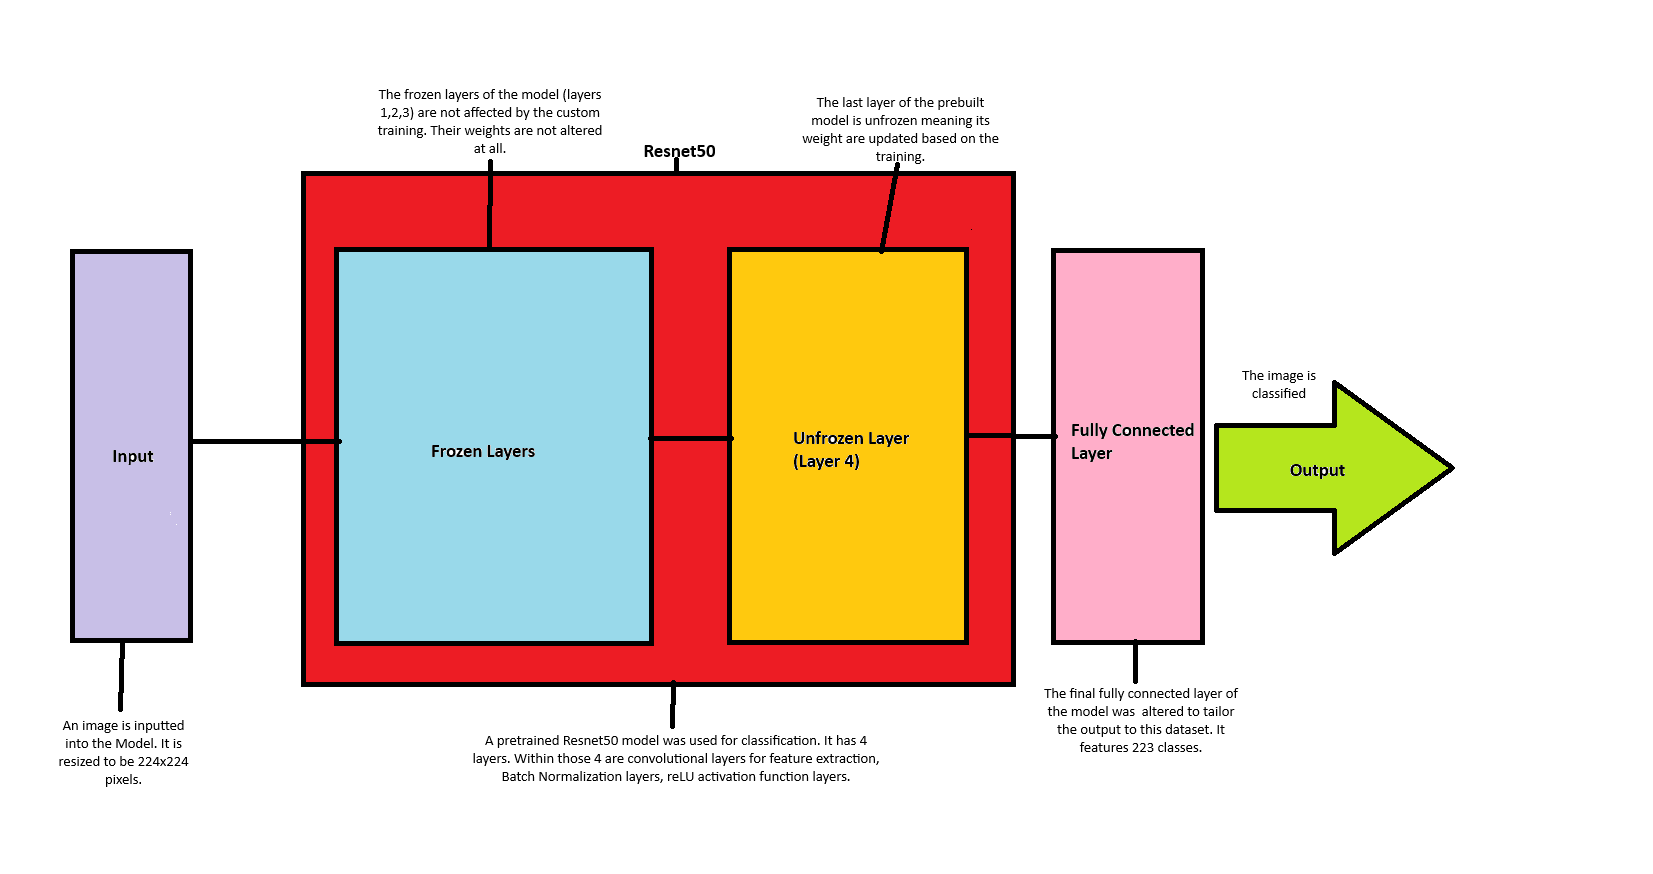

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# number of classes from the dataset, model output size needs to be equal to this
num_classes = len(train_dataset.classes)

# Load a pre-trained ResNet50 model
model_ft = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Freeze all layers in the base model --> means there weights will not be updated during the inital trining phase,
# because they have already learned useful training features that you don't want to alter
for param in model_ft.parameters():
    param.requires_grad = False #line freezes the layer

# Replace the fully connected layer classifier to match my output requirements
num_ftrs = model_ft.fc.in_features #number of input features (2048)
model_ft.fc = nn.Linear(num_ftrs, num_classes) #fc--> the original fully connected layer, replaces thatwith a new layer (nn.Linear) which takes
# same number of inpputs but different number of outputs(=num_classes) then the original

# Unfreeze some layers for fine-tuning (e.g., the last few blocks)
# Adjust the number of layers to unfreeze based on your needs
for name, child in model_ft.named_children(): #accesses named modules of the model
   if name in ['layer4', 'fc']: # Unfreeze the last convolutional block and the new fully connected layer
       for param in child.parameters():
           param.requires_grad = True

# Define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device) #uses gpu for training

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() #standard loss function for mulitclass classification, calculates difference between predicted probabilies and true labels
optimizer = optim.Adam(model_ft.parameters(), lr=1e-4) #sets learning rate of optimizer, optimizer updates model weights

print("PyTorch model defined and moved to:", device)

PyTorch model defined and moved to: cuda


# Resnet50 Training
This section runs through the training of the CNN model, keeping track of the highest accuracy epoch.

The training process involves iterating over the training dataset multiple times. Each full pass through the training dataset is called an **epoch**. During each epoch, the model processes the data in smaller batches. For each batch, it makes predictions, calculates the **loss** (which measures how far off the predictions are from the true labels), and then adjusts its internal weights through a process called **backpropagation** and **optimization** to reduce the loss.

We track the training **accuracy** and **loss** at the end of each epoch to monitor the model's performance. The goal is to see the loss decrease and the accuracy increase over epochs. We also save the model's weights whenever we achieve a new best accuracy on the training data, ensuring that we keep the version of the model that performed best during training.

Epoch 0/19
----------
Train Loss: 0.2828 Acc: 0.9430
New best accuracy: 0.9430. Saving model weights.
Epoch 1/19
----------
Train Loss: 0.0169 Acc: 0.9959
New best accuracy: 0.9959. Saving model weights.
Epoch 2/19
----------
Train Loss: 0.0090 Acc: 0.9978
New best accuracy: 0.9978. Saving model weights.
Epoch 3/19
----------
Train Loss: 0.0063 Acc: 0.9986
New best accuracy: 0.9986. Saving model weights.
Epoch 4/19
----------
Train Loss: 0.0041 Acc: 0.9990
New best accuracy: 0.9990. Saving model weights.
Epoch 5/19
----------
Train Loss: 0.0036 Acc: 0.9992
New best accuracy: 0.9992. Saving model weights.
Epoch 6/19
----------
Train Loss: 0.0023 Acc: 0.9994
New best accuracy: 0.9994. Saving model weights.
Epoch 7/19
----------
Train Loss: 0.0022 Acc: 0.9994
New best accuracy: 0.9994. Saving model weights.
Epoch 8/19
----------
Train Loss: 0.0018 Acc: 0.9996
New best accuracy: 0.9996. Saving model weights.
Epoch 9/19
----------
Train Loss: 0.0014 Acc: 0.9997
New best accuracy: 0.9997. Sa

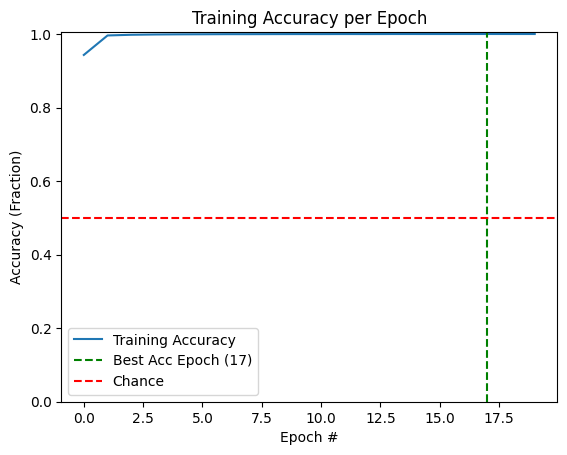

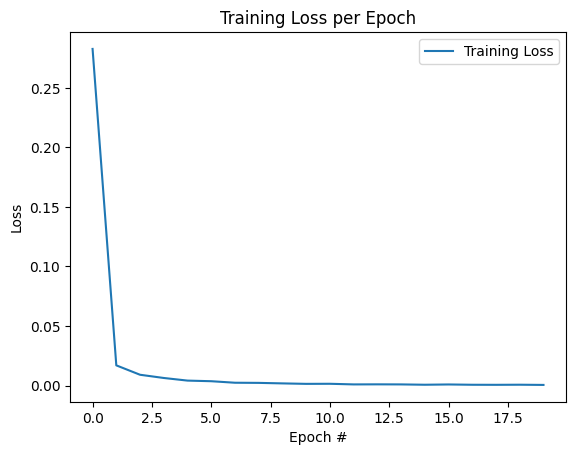

In [ ]:
import time  # Import the time module for potential timing (though not used in the current loop)
import copy  # Import the copy module for deep copying model weights
import torch # Import the main PyTorch library

# Number of epochs to train
num_epochs = 20 # Set the total number of training epochs

# Lists to store training history
history = {'accuracy': [], 'loss': []} # Initialize a dictionary to store accuracy and loss for each epoch

best_model_wts = copy.deepcopy(model_ft.state_dict()) # Create a deep copy of the initial model weights to save the best ones
best_acc = 0.0 # Initialize the best accuracy found so far to 0.0

for epoch in range(num_epochs): # Loop through each epoch
    print(f'Epoch {epoch}/{num_epochs - 1}') # Print the current epoch number
    print('-' * 10) # Print a separator line

    # Each epoch has a training phase
    model_ft.train()  # Set the model to training mode (enables dropout, batch norm updates, etc.)

    running_loss = 0.0 # Initialize the running loss for the current epoch
    running_corrects = 0 # Initialize the number of correctly predicted samples for the current epoch

    # Iterate over data.
    for inputs, labels in train_loader: # Loop through each batch of data in the training data loader
        inputs = inputs.to(device) # Move the input images to the specified device (GPU or CPU)
        labels = labels.to(device) # Move the corresponding labels to the specified device

        # zero the parameter gradients
        optimizer.zero_grad() # Zero the gradients of the model's parameters to prevent accumulation

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True): # Enable gradient calculation (important for training)
            outputs = model_ft(inputs) # Perform a forward pass: feed the inputs through the model to get outputs (logits)
            _, preds = torch.max(outputs, 1) # Get the predicted class index by finding the maximum value in the output for each sample
            loss = criterion(outputs, labels) # Calculate the loss between the model's outputs and the true labels

            # backward + optimize only if in training phase
            loss.backward() # Perform a backward pass: calculate gradients of the loss with respect to the model's parameters
            optimizer.step() # Update the model's weights using the calculated gradients and the optimizer

        # statistics
        running_loss += loss.item() * inputs.size(0) # Accumulate the loss for the current batch
        running_corrects += torch.sum(preds == labels.data) # Accumulate the number of correct predictions for the current batch

    epoch_loss = running_loss / len(train_dataset) # Calculate the average loss for the current epoch
    epoch_acc = running_corrects.double() / len(train_dataset) # Calculate the accuracy for the current epoch

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}') # Print the training loss and accuracy for the current epoch

    # Store history
    history['loss'].append(epoch_loss) # Append the epoch loss to the history dictionary
    history['accuracy'].append(epoch_acc.item()) # Append the epoch accuracy to the history dictionary (.item() gets the scalar value from the tensor)

    # deep copy the model if it has the best accuracy
    if epoch_acc > best_acc: # Check if the current epoch's accuracy is better than the best accuracy found so far
        best_acc = epoch_acc # Update the best accuracy
        best_model_wts = copy.deepcopy(model_ft.state_dict()) # Save a deep copy of the model's state dictionary (weights)
        print(f'New best accuracy: {best_acc:.4f}. Saving model weights.') # Print a message indicating a new best accuracy and saving
        torch.save(model_ft.state_dict(), 'best_model_weights.pth') # Save the best model weights to a file

# Print training completion message and best accuracy
print('Training complete') # Print a message indicating training is complete
print(f'Best train Acc: {best_acc:.4f}') # Print the best training accuracy achieved

# load best model weights
model_ft.load_state_dict(best_model_wts) # Load the weights of the best performing model back into the model

# You would need to create a similar plotting function for PyTorch history
plot_acc(history) # Call the plotting function to visualize the training history

# Resnet50 Testing
Now the model will be tested on the testing portion of the dataset created in the data transformation cell above. Since this is only one run through, we are switching the model to `eval` mode, and not using any gradient calculations. This is a relatively accurate assessment of how accurate our model is on unseen data.

During the testing phase:
- The model is set to `eval()` mode, which disables dropout layers (as they are only used during training for regularization) and uses the learned statistics for batch normalization layers (instead of calculating statistics for the current batch, which helps ensure consistent results during inference).
- `torch.no_grad()` is used to disable gradient calculations. This is crucial during testing and inference because we don't need to compute gradients to update model weights, which saves memory and computation time.
- The test data is loaded in batches using the `test_loader`.
- For each batch, a forward pass is performed to get the model's predictions (logits). The logits are the raw output scores from the model before applying a final activation function like softmax.
- The loss is calculated using the `criterion` (CrossEntropyLoss). This loss function is suitable for multi-class classification and measures the difference between the predicted probability distribution and the true class labels.
- The number of correctly predicted samples is accumulated to calculate the overall accuracy. This is done by comparing the predicted class (the one with the highest logit score) to the true label for each sample in the batch.
- Finally, the average test loss and accuracy are calculated and printed to provide an overall performance metric for the model on the unseen test data. This gives a good indication of how well the trained model is expected to perform on new, real-world examples.

In [ ]:
# Evaluate the model on the test set
model_ft.eval() # Set the model to evaluation mode (disables dropout, batch norm updates are frozen)

running_loss = 0.0 # Initialize the running loss for the test set
running_corrects = 0 # Initialize the number of correctly predicted samples for the test set

# Disable gradient calculation for evaluation
with torch.no_grad(): # Use torch.no_grad() to disable gradient calculations during evaluation
    for inputs, labels in test_loader: # Loop through each batch of data in the test data loader
        inputs = inputs.to(device) # Move the input images to the specified device (GPU or CPU)
        labels = labels.to(device) # Move the corresponding labels to the specified device

        outputs = model_ft(inputs) # Perform a forward pass
        _, preds = torch.max(outputs, 1) # Get the predicted class index
        loss = criterion(outputs, labels) # Calculate the loss

        # statistics
        running_loss += loss.item() * inputs.size(0) # Accumulate the loss for the current batch
        running_corrects += torch.sum(preds == labels.data) # Accumulate the number of correct predictions for the current batch

test_loss = running_loss / len(test_dataset) # Calculate the average loss for the test set
test_acc = running_corrects.double() / len(test_dataset) # Calculate the accuracy for the test set

print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}') # Print the test loss and accuracy

Test Loss: 0.0043 Acc: 0.9989


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

def predict_single_image_torch(model, img_path, class_names, target_size=(224, 224)):
    """
    Predicts the class of a single image using a trained PyTorch model.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        img_path (str): The path to the image file.
        class_names (list): A list of class names in the order corresponding to the model's output.
        target_size (tuple): The target size (height, width) for resizing the image.

    Returns:
        str: The predicted class name.
    """
    # Load the image
    img = Image.open(img_path).convert('RGB') # Ensure image is in RGB format

    # Define the same transformations used for testing data
    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transformations and add a batch dimension because model expects (batch_size, channnels, height, width) format
    img_tensor = preprocess(img).unsqueeze(0)

    # Set the model to evaluation mode
    model.eval()

    # Move the image tensor to the same device as the model
    device = next(model.parameters()).device # Get the device from the model
    img_tensor = img_tensor.to(device)

    # Perform inference
    with torch.no_grad(): # Disable gradient calculation for inference
        outputs = model(img_tensor)

    # Get the predicted class index
    _, predicted_idx = torch.max(outputs, 1)
    predicted_idx = predicted_idx.item() # Get the scalar index

    # Return the predicted class name
    return class_names[predicted_idx]

# Usage example (assuming 'model_ft' is your trained PyTorch model from previous cells
# and 'train_dataset.classes' contains your class names)
# Make sure to replace 'path/to/your/image.jpg' with the actual path to the image you want to predict
try:
    # Use the model_ft trained in the previous cells
    predicted_label = predict_single_image_torch(model_ft, "app.jpeg", train_dataset.classes)
    print(predicted_label)
except NameError:
    print("Please ensure that 'model_ft' and 'train_dataset' are defined by running the previous cells.")
except FileNotFoundError:
    print("Error: The image file 'app.jpeg' was not found. Please provide the correct path to the image.")
except Exception as e:
    print(f"An error occurred during prediction: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
AppleRedYellow


### Model Summary (ResNet50)
This section provides a summary of the ResNet50 model architecture using `torchsummary`. The summary output details each layer or module within the model, including:

- **Layer (type)**: The type of layer (e.g., Conv2d, BatchNorm2d, ReLU, Bottleneck, Linear).
- **Output Shape**: The shape of the tensor output from that layer. The `-1` indicates the batch size, which can vary.
- **Param #**: The number of trainable parameters in that specific layer.

The summary also provides a breakdown of the total parameters, trainable parameters, non-trainable parameters, and estimated memory usage for the input, forward/backward pass, and parameters. This information is useful for understanding the model's complexity and resource requirements.

In [ ]:
from torchsummary import summary
import torch
import torch.nn as nn
from torchvision import models

#Define Model Architecture
model_ft = models.resnet50(weights=None)
# Adjust the number of output features to match your number of classes
try:
    num_classes = len(train_dataset.classes)
except NameError:
    print("Warning: train_dataset not found. Assuming 223 classes based on previous output.")
    num_classes = 223 # Defaulting to 223 based on previous cell output

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# Determine the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved best model weights
try:
    model_ft.load_state_dict(torch.load('best_model_weights.pth', map_location=device))
    print("Successfully loaded model weights from 'best_model_weights.pth'")
except FileNotFoundError:
    print("Error: 'best_model_weights.pth' not found. Please ensure the file exists.")
    # Handle the error or exit if weights are essential
except Exception as e:
    print(f"An error occurred while loading model weights: {e}")


# Move the model to the device
model_ft.to(device)

# Print the summary of the model
summary(model_ft, input_size=(3, 224, 224))


Successfully loaded model weights from 'best_model_weights.pth'
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256,

#EffecientNet Model

* * *
Now I am going to try to test the accuracy of another popular CNN model: EffecientNet. We are going to repeat the same process as what we did for the first architecture, this time with this new model to compare accuracy scores.

EfficientNet is a family of convolutional neural networks that achieve state-of-the-art accuracy with fewer parameters and less computation compared to other CNNs. This is primarily due to a technique called **compound scaling**, which uniformly scales network depth, width, and resolution with a set of fixed scaling coefficients.

In this section, we will set up, train, and test an EfficientNet model on the fruit dataset, following a similar workflow as with the ResNet50 model:

1.  **Model Setup**: We will load a pre-trained EfficientNet model (specifically EfficientNetB0 in the code below) and modify its final layer to classify our specific number of fruit classes. Similar to ResNet50, we will use transfer learning by leveraging the features learned from a large dataset like ImageNet.
2.  **Training**: We will train the EfficientNet model on the training dataset. The training process involves feeding the data in batches, calculating the loss, and updating the model's weights using an optimizer. We will track the training loss and accuracy per epoch and save the best performing model weights.
3.  **Testing**: After training, we will evaluate the trained EfficientNet model on the unseen test dataset to assess its performance and generalization ability. We will calculate and report the test loss and accuracy.

By comparing the performance metrics (especially test accuracy) of EfficientNet and ResNet50 on the same dataset, we can get an idea of which architecture is more suitable for this specific image classification task.

In [ ]:
import torch # Import the main PyTorch library
import torch.nn as nn # Import the neural network module from PyTorch
import torch.optim as optim # Import the optimization module from PyTorch
from torchvision import models # Import pre-trained models from torchvision

# Get the number of classes from your dataset (assuming train_dataset is available)
num_classes = len(train_dataset.classes)

# Load a pre-trained EfficientNetB0 model from torchvision.
model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Freeze all layers in the base model
for param in model_eff.parameters():
    param.requires_grad = False

# Replace the classifier layer to match the number of classes in your dataset.
model_eff.classifier = nn.Sequential(
    nn.Dropout(0.2), # Add a dropout layer for regularization
    nn.Linear(model_eff.classifier[1].in_features, num_classes) # The linear layer for classification
)


# Unfreeze some layers for fine-tuning.
for name, child in model_eff.named_children():
    # Example (might need adjustment based on the specific EfficientNet version):
    if name in ['features']: # Unfreeze the features (convolutional base)
         for param in child.parameters():
             param.requires_grad = True

# Define the device to use for training (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device.
model_eff = model_eff.to(device)

# Define the loss function.
criterion = nn.CrossEntropyLoss()

# Define the optimizer.
optimizer = optim.Adam(model_eff.parameters(), lr=1e-4)

# Print a message indicating that the PyTorch model has been defined and moved to the device.
print("PyTorch EfficientNet model defined and moved to:", device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\kuruk/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 66.5MB/s]

PyTorch EfficientNet model defined and moved to: cuda


Epoch 0/19
----------
Train Loss: 0.2471 Acc: 0.9593
New best accuracy: 0.9593. Saving model weights.
Epoch 1/19
----------
Train Loss: 0.0150 Acc: 0.9966
New best accuracy: 0.9966. Saving model weights.
Epoch 2/19
----------
Train Loss: 0.0088 Acc: 0.9979
New best accuracy: 0.9979. Saving model weights.
Epoch 3/19
----------
Train Loss: 0.0063 Acc: 0.9987
New best accuracy: 0.9987. Saving model weights.
Epoch 4/19
----------
Train Loss: 0.0056 Acc: 0.9986
Epoch 5/19
----------
Train Loss: 0.0045 Acc: 0.9989
New best accuracy: 0.9989. Saving model weights.
Epoch 6/19
----------
Train Loss: 0.0039 Acc: 0.9991
New best accuracy: 0.9991. Saving model weights.
Epoch 7/19
----------
Train Loss: 0.0036 Acc: 0.9992
New best accuracy: 0.9992. Saving model weights.
Epoch 8/19
----------
Train Loss: 0.0034 Acc: 0.9992
Epoch 9/19
----------
Train Loss: 0.0035 Acc: 0.9992
Epoch 10/19
----------
Train Loss: 0.0023 Acc: 0.9993
New best accuracy: 0.9993. Saving model weights.
Epoch 11/19
----------
T

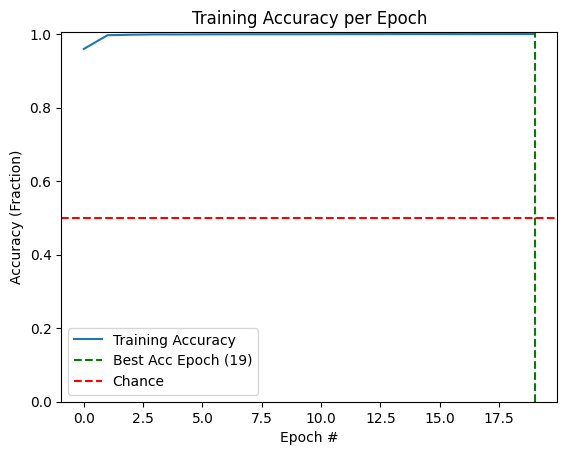

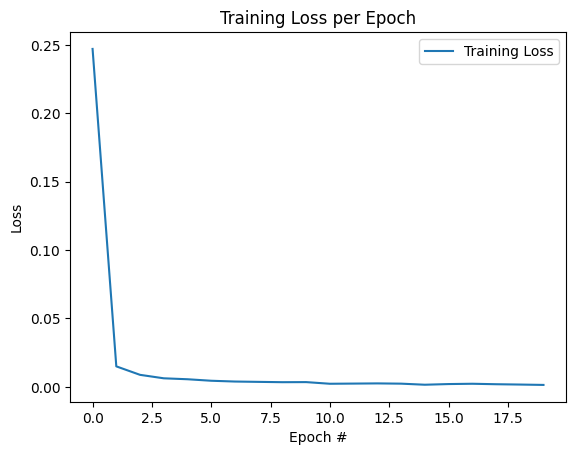

In [ ]:
import time  # Import the time module for potential timing
import copy  # Import the copy module for deep copying model weights
import torch # Import the main PyTorch library

# Number of epochs to train
num_epochs = 20 # Set the total number of training epochs

# Lists to store training history
history = {'accuracy': [], 'loss': []} # Initialize a dictionary to store accuracy and loss for each epoch

best_model_wts = copy.deepcopy(model_eff.state_dict()) # Create a deep copy of the initial model weights to save the best ones
best_acc = 0.0 # Initialize the best accuracy found so far to 0.0

for epoch in range(num_epochs): # Loop through each epoch
    print(f'Epoch {epoch}/{num_epochs - 1}') # Print the current epoch number
    print('-' * 10) # Print a separator line

    # Each epoch has a training phase
    model_eff.train()  # Set the model to training mode (enables dropout, batch norm updates, etc.)

    running_loss = 0.0 # Initialize the running loss for the current epoch
    running_corrects = 0 # Initialize the number of correctly predicted samples for the current epoch

    # Iterate over data.
    for inputs, labels in train_loader: # Loop through each batch of data in the training data loader
        inputs = inputs.to(device) # Move the input images to the specified device (GPU or CPU)
        labels = labels.to(device) # Move the corresponding labels to the specified device

        # zero the parameter gradients
        optimizer.zero_grad() # Zero the gradients of the model's parameters to prevent accumulation

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True): # Enable gradient calculation (important for training)
            outputs = model_eff(inputs) # Perform a forward pass: feed the inputs through the model to get outputs (logits)
            _, preds = torch.max(outputs, 1) # Get the predicted class index by finding the maximum value in the output for each sample
            loss = criterion(outputs, labels) # Calculate the loss between the model's outputs and the true labels

            # backward + optimize only if in training phase
            loss.backward() # Perform a backward pass: calculate gradients of the loss with respect to the model's parameters
            optimizer.step() # Update the model's weights using the calculated gradients and the optimizer

        # statistics
        running_loss += loss.item() * inputs.size(0) # Accumulate the loss for the current batch
        running_corrects += torch.sum(preds == labels.data) # Accumulate the number of correct predictions for the current batch

    epoch_loss = running_loss / len(train_dataset) # Calculate the average loss for the current epoch
    epoch_acc = running_corrects.double() / len(train_dataset) # Calculate the accuracy for the current epoch

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}') # Print the training loss and accuracy for the current epoch

    # Store history
    history['loss'].append(epoch_loss) # Append the epoch loss to the history dictionary
    history['accuracy'].append(epoch_acc.item()) # Append the epoch accuracy to the history dictionary (.item() gets the scalar value from the tensor)

    # deep copy the model if it has the best accuracy
    if epoch_acc > best_acc: # Check if the current epoch's accuracy is better than the best accuracy found so far
        best_acc = epoch_acc # Update the best accuracy
        best_model_wts = copy.deepcopy(model_eff.state_dict()) # Save a deep copy of the model's state dictionary (weights)
        print(f'New best accuracy: {best_acc:.4f}. Saving model weights.') # Print a message indicating a new best accuracy and saving
        torch.save(model_eff.state_dict(), 'best_efficientnet_weights.pth') # Save the best model weights to a file

# Print training completion message and best accuracy
print('Training complete') # Print a message indicating training is complete
print(f'Best train Acc: {best_acc:.4f}') # Print the best training accuracy achieved

# load best model weights
model_eff.load_state_dict(best_model_wts) # Load the weights of the best performing model back into the model

# You would need to create a similar plotting function for PyTorch history
plot_acc(history) # Call the plotting function to visualize the training history